In [1]:

import gc
import os
import random   

import numpy as np
import pandas as pd

from tqdm import tqdm


### Load Data

In [2]:
## https://github.com/JeffSackmann/tennis_wta

DATA_PATH = 'D://Medium'
os.listdir(DATA_PATH)


['ncaam_sample_data.csv',
 'wta_matches_2018.csv',
 'wta_matches_2019.csv',
 'wta_matches_2020.csv',
 'wta_matches_2021.csv',
 'wta_matches_2022.csv',
 'wta_matches_2023.csv',
 'wta_matches_qual_itf_2018.csv',
 'wta_matches_qual_itf_2019.csv',
 'wta_matches_qual_itf_2020.csv',
 'wta_matches_qual_itf_2021.csv',
 'wta_matches_qual_itf_2022.csv',
 'wta_matches_qual_itf_2023.csv']

In [365]:

qual_itf_data = pd.concat([
    pd.read_csv(os.path.join(DATA_PATH, 'wta_matches_qual_itf_2018.csv')),
    pd.read_csv(os.path.join(DATA_PATH, 'wta_matches_qual_itf_2019.csv')),
    pd.read_csv(os.path.join(DATA_PATH, 'wta_matches_qual_itf_2020.csv')),
    pd.read_csv(os.path.join(DATA_PATH, 'wta_matches_qual_itf_2021.csv')),
    pd.read_csv(os.path.join(DATA_PATH, 'wta_matches_qual_itf_2022.csv')),
    pd.read_csv(os.path.join(DATA_PATH, 'wta_matches_qual_itf_2023.csv'))
], axis=0).reset_index(drop=True)


C:\Users\Blake\AppData\Local\Temp\ipykernel_35460\3235405204.py:3: DtypeWarning: Columns (8,16) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(os.path.join(DATA_PATH, 'wta_matches_qual_itf_2019.csv')),
C:\Users\Blake\AppData\Local\Temp\ipykernel_35460\3235405204.py:5: DtypeWarning: Columns (8,16) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(os.path.join(DATA_PATH, 'wta_matches_qual_itf_2021.csv')),
C:\Users\Blake\AppData\Local\Temp\ipykernel_35460\3235405204.py:6: DtypeWarning: Columns (8,16) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(os.path.join(DATA_PATH, 'wta_matches_qual_itf_2022.csv')),
C:\Users\Blake\AppData\Local\Temp\ipykernel_35460\3235405204.py:7: DtypeWarning: Columns (8,16) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(os.path.join(DATA_PATH, 'wta_matches_qual_itf_2023.csv'))


In [366]:
tour_level = pd.concat([
    pd.read_csv(os.path.join(DATA_PATH, 'wta_matches_2018.csv')),
    pd.read_csv(os.path.join(DATA_PATH, 'wta_matches_2019.csv')),
    pd.read_csv(os.path.join(DATA_PATH, 'wta_matches_2020.csv')),
    pd.read_csv(os.path.join(DATA_PATH, 'wta_matches_2021.csv')),
    pd.read_csv(os.path.join(DATA_PATH, 'wta_matches_2022.csv')),
    pd.read_csv(os.path.join(DATA_PATH, 'wta_matches_2023.csv'))
], axis=0).reset_index(drop=True)

wta_sample_data = pd.concat([qual_itf_data, tour_level], axis=0).reset_index(drop=True)
wta_sample_data['tourney_date'] = pd.to_datetime(wta_sample_data['tourney_date'].apply(lambda x: f"{str(x)[4:-2]}-{str(x)[-2:]}-{str(x)[:4]}"))
wta_sample_data = wta_sample_data.sort_values(by=['tourney_id','match_num']).reset_index(drop=True)
wta_sample_data = wta_sample_data.drop_duplicates(subset=['tourney_id','match_num','winner_id']).reset_index(drop=True)


In [5]:

players = set(wta_sample_data['winner_id'].values)
losers = set(wta_sample_data['loser_id'].values)
players = players.union(losers)


### Run Classic Elo

In [6]:

player_names = {}
win_names = wta_sample_data[['winner_id','winner_name']].copy().set_index('winner_id').to_dict()['winner_name']
lose_names = wta_sample_data[['loser_id','loser_name']].copy().set_index('loser_id').to_dict()['loser_name']
player_names.update(win_names)
player_names.update(lose_names)


In [7]:

class StatefulSystem:
    def __init__(self):
        self.history = []  # to store history of predictions and results

    def predict_1v1(self, player1, player2, **kwargs):
        raise NotImplementedError  # This method should be implemented in child classes

    def update_1v1(self, player1, player2, result, **kwargs):
        raise NotImplementedError  # This method should be implemented in child classes
        
class PlayerNode():
    def __init__(self, rating):
        self.rating=rating
        
class EloNode(PlayerNode):
    def __init__(self,_id, name, rating=1500):
        super().__init__(rating)
        self._id = _id
        self.name = name
        self.rating = rating
        self.rank = 200
        
class EloSystem(StatefulSystem):
    def __init__(self, k_factor, meta_functions=None):
        super().__init__()
        self.history = []
        self.k_factor = k_factor
        ## for edge info like home, days off
        self.meta_functions = meta_functions

    def predict_1v1(self, player1, player2, **kwargs):
        # Meta information can be accessed as dictionary items, e.g., kwargs['is_home'], kwargs['days_off']
        rd = player1.rating - player2.rating
        if self.meta_functions is not None:
            ## add all adjustments for meta information
            for meta_key, meta_function in self.meta_functions.items():
                rd += meta_function(kwargs[meta_key])
        prediction = 1/(1+10**(-rd/400))
        return prediction
    def update_1v1(self, prediction, result):
        points_exchanged = self.k_factor*(result-prediction)
        return points_exchanged
    
    def play_match(self, p1, p2, result, **kwargs):
        prediction = self.predict_1v1(p1, p2, **kwargs)
        ratings_delta = self.update_1v1(prediction, result)
        self.history.append([p1._id, p1.name, p2._id, p2.name, p1.rating, p2.rating, prediction, result, ratings_delta])
        p1.rating+=ratings_delta
        p2.rating-=ratings_delta
        return p1, p2
    
    def get_history(self):
        return pd.DataFrame(self.history, columns=['p1_id','p1_name','p2_id','p2_name','p1_rating','p2_rating','prediction','result','ratings_delta'])

elo_sys = EloSystem(k_factor=50)
player_ratings = {_id:EloNode(_id, name, 1500) for _id, name in player_names.items()}
for index, row in tqdm(wta_sample_data.iterrows(), total=len(wta_sample_data)):
    ## randomize who is p1 and who is p2
    match_participants = [row['winner_id'], row['loser_id']]
    random.shuffle(match_participants)
    p1_id, p2_id = match_participants
    p1_node = player_ratings[p1_id]
    p2_node = player_ratings[p2_id]
    result = 1 if p1_node._id == row['winner_id'] else 0
    p1_node, p2_node = elo_sys.play_match(p1_node, p2_node, result)
    
    ## just tracking world ranking
    if result == 1:
        p1_node.rank = row['winner_rank']
        p2_node.rank = row['loser_rank']
    else:
        p1_node.rank = row['loser_rank']
        p2_node.rank = row['winner_rank']
    player_ratings[p1_id] = p1_node
    player_ratings[p2_id] = p2_node
    
    
hist = elo_sys.get_history()
hist
    

100%|███████████████████████████████████████████████████████████████████████| 145608/145608 [00:03<00:00, 36595.38it/s]


,p1_id,p1_name,p2_id,p2_name,p1_rating,p2_rating,prediction,result,ratings_delta
0,202702,Tereza Smitkova,211222,Jamie Loeb,1500.000000,1500.000000,0.500000,1,25.000000
1,211685,Rebecca Sramkova,204430,Antonia Lottner,1500.000000,1500.000000,0.500000,1,25.000000
2,213889,Greet Minnen,212044,Katharina Gerlach,1500.000000,1500.000000,0.500000,1,25.000000
3,201697,Kristyna Pliskova,206349,Mayo Hibi,1500.000000,1500.000000,0.500000,1,25.000000
4,213779,Raluka Serban,202446,Eugenie Bouchard,1500.000000,1500.000000,0.500000,0,-25.000000
...,...,...,...,...,...,...,...,...,...
145603,222866,Katherine Hui,221374,Danielle Willson,1721.003373,1596.003660,0.672509,1,16.374536
145604,263685,Alessia Cau,215840,Haley Giavara,1576.349293,1755.683189,0.262633,0,-13.131642
145605,259853,Eryn Cayetano,203288,Jia Jing Lu,1721.567422,1743.831527,0.468003,0,-23.400158
145606,215840,Haley Giavara,222866,Katherine Hui,1768.814832,1737.377909,0.545118,1,22.744085


In [8]:
from sklearn.metrics import log_loss
#50: 0.5812750355074674, -0.750812
#60: 0.5780273230899833, -0.748345
grade_cutoff = int(0.2*len(hist))
log_loss(hist[-grade_cutoff:]['result'].values, hist[-grade_cutoff:]['prediction'].values)

0.5812750355074674

In [9]:
rtg_df = pd.DataFrame([[k,v.name, v.rating, v.rank] for k,v in player_ratings.items()], columns=['id','name','rating','world_rank'])
rtg_df[['rating','world_rank']].corr()

,rating,world_rank
rating,1.000000,-0.750812
world_rank,-0.750812,1.000000


In [10]:

rtg_df.sort_values(by='rating', ascending=False).head(20)


,id,name,rating,world_rank
389,216347,Iga Swiatek,2433.015675,1.0
70,214981,Elena Rybakina,2416.040581,7.0
82,202458,Ashleigh Barty,2411.362229,1.0
107,214544,Aryna Sabalenka,2396.156105,2.0
103,201520,Petra Kvitova,2379.114090,16.0
113,202468,Jessica Pegula,2357.773875,3.0
182,201594,Simona Halep,2318.828213,15.0
177,206252,Barbora Krejcikova,2286.811707,12.0
1842,221103,Cori Gauff,2277.754983,6.0
15,202505,Belinda Bencic,2276.576134,12.0


### Create Pytorch Elo Classes


In [41]:

import torch.nn as nn

# One neuron to learn scaling and a sigmoid activation function.
class EloPredictNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1, bias=False)  # No bias so that ratings delta of 0 = 50% win prob

    def forward(self, rd):
        return torch.sigmoid(self.linear(rd))
    
class EloUpdateNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1, bias=False)  # No bias so that matches are symmetrical (no advantage to being player A)
        
    def forward(self, pred_error):
        return self.linear(pred_error)
    
class NetworkNode(PlayerNode):
    def __init__(self,_id, name, rating=0):
        super().__init__(rating)
        self._id = _id
        self.name = name
        self.rating = rating
        self.last_rating = rating
        self.last_error = 0.5
        self.rank = 200 



### Let's try learning the weights

In [80]:

## split into train/test
percent_30 = int(0.3*len(wta_sample_data))
wta_sample_data = wta_sample_data.sort_values(by=['tourney_date','match_num']).reset_index(drop=True)
train = wta_sample_data.copy()[:-percent_30]
test = wta_sample_data.copy()[-percent_30:]
 
## split into train/test/val
# percent_20 = int(0.2*len(wta_sample_data))
# train = wta_sample_data.copy()[:-2*percent_20]
# test = wta_sample_data.copy()[-2*percent_20:-1*percent_20]
# val = wta_sample_data.copy()[-1*percent_20:]
# print(len(train), len(test), len(val))


In [127]:
list(wta_sample_data)

['tourney_id',
 'tourney_name',
 'surface',
 'draw_size',
 'tourney_level',
 'tourney_date',
 'match_num',
 'winner_id',
 'winner_seed',
 'winner_entry',
 'winner_name',
 'winner_hand',
 'winner_ht',
 'winner_ioc',
 'winner_age',
 'loser_id',
 'loser_seed',
 'loser_entry',
 'loser_name',
 'loser_hand',
 'loser_ht',
 'loser_ioc',
 'loser_age',
 'score',
 'best_of',
 'round',
 'minutes',
 'w_ace',
 'w_df',
 'w_svpt',
 'w_1stIn',
 'w_1stWon',
 'w_2ndWon',
 'w_SvGms',
 'w_bpSaved',
 'w_bpFaced',
 'l_ace',
 'l_df',
 'l_svpt',
 'l_1stIn',
 'l_1stWon',
 'l_2ndWon',
 'l_SvGms',
 'l_bpSaved',
 'l_bpFaced',
 'winner_rank',
 'winner_rank_points',
 'loser_rank',
 'loser_rank_points']

In [43]:
import torch
from copy import copy
from torch.optim import Adam, SGD

predict_model = EloPredictNN()
predict_optimizer = Adam(predict_model.parameters(), lr=1e-5)

update_model = EloUpdateNN()
update_optimizer = Adam(update_model.parameters(), lr=1e-5)

batch_size = 24 ## in effect it will be 2x size
num_batches = len(train)//batch_size
num_epochs = 5
best_val_loss = np.inf

for j in range(num_epochs):
    network_player_ratings = {_id:NetworkNode(_id, name, np.random.random()-0.5) for _id, name in player_names.items()}
    epoch_loss = []
    predict_model.train()
    update_model.train()
    for i in tqdm(range(num_batches-1), total=num_batches-1):
        predict_optimizer.zero_grad()
        update_optimizer.zero_grad()
        train_data = train[i*batch_size:(i+1)*batch_size].copy()

        ## randomize who is p1 and who is p2
        match_participants_1 = train_data[['winner_id','loser_id','winner_rank','loser_rank']]
        rank_dict = match_participants_1.copy().set_index('winner_id').to_dict()['winner_rank']
        rank_2_dict = match_participants_1.copy().set_index('loser_id').to_dict()['loser_rank']
        rank_dict.update(rank_2_dict)

        match_participants_2 = match_participants_1.copy()[['loser_id','winner_id','loser_rank','winner_rank']]
        match_participants = pd.concat([match_participants_1, match_participants_2], axis=0).reset_index(drop=True).values
        input_order = list(range(batch_size*2))
        random.shuffle(input_order)
        results = torch.cat([torch.ones(batch_size), torch.zeros(batch_size)]).view(-1,1)
        
        p1_nodes = [network_player_ratings[match_participants[k][0]] for k in input_order]
        p2_nodes = [network_player_ratings[match_participants[k][1]] for k in input_order]
        
        predict_X = torch.Tensor([p2_nodes[k].rating-p1_nodes[k].rating for k in range(len(p1_nodes))]).view(-1,1)
        predict_y = torch.Tensor([results[k] for k in input_order]).view(-1,1)
        

        ## I found that only updating one model at a time seems to give more stable results
        ## worth investigating further
        update_or_predict = np.random.random()
        
        if update_or_predict>0.5:
            ## PREDICT MODEL (easy part)
            ## have to make it symmetrical (p2_rating-p1_rating and p1_rating-p2_rating)
            predictions = predict_model(predict_X)
            
            predict_loss = nn.BCELoss()(predictions, predict_y)
            predict_loss.backward()

            # Update the model's parameters
            ## for the first few iterations, let ratings stabilize
            if (j>0)&(i < 20):
                continue
            elif (j>1)&(i < 100):
                continue
            else:
                predict_optimizer.step()
            # Zero the gradients since PyTorch accumulates them
            predict_optimizer.zero_grad()
        
        else:
            ## UPDATE MODEL (slightly harder)
            ## use previous game's results to calculate loss of the update model
            predictions = predict_model(predict_X)
            predict_optimizer.zero_grad()
            
            ## directionality is important here, last error is simply result - prediction (is negative if the player loses)
            p1_update_X = torch.Tensor([p1_node.last_error for p1_node in p1_nodes]).view(-1,1)
            p2_update_X = torch.Tensor([p2_node.last_error for p2_node in p2_nodes]).view(-1,1)

            p1_update_predictions = update_model(p1_update_X)
            p2_update_predictions = update_model(p2_update_X)

            ## want both baseline predict model (no update) and predict model with updates. Compare to create loss
            baseline_X = torch.Tensor([p2_nodes[k].last_rating-p1_nodes[k].last_rating for k in range(len(p1_nodes))]).view(-1,1)
            update_model_X = torch.Tensor([p2_nodes[k].last_rating+p2_update_predictions[k] - p1_nodes[k].last_rating+p1_update_predictions[k] for k in range(len(p1_nodes))])

            baseline_predictions = predict_model(baseline_X)
            update_model_predictions = predict_model(update_model_X)
            baseline_BCE = nn.BCELoss()(baseline_predictions, predict_y)
            update_model_BCE = nn.BCELoss()(update_model_predictions, predict_y)
            ## lower is better, has to be negative if improving ratings
            update_loss = update_model_BCE-baseline_BCE
            update_loss.backward()
            ## skip the first few iterations of the later epochs to give some time for ratings to develop
            if (j>0)&(i < 25):
                continue
            elif (j>1)&(i < 100):
                continue
            else:
                update_optimizer.step()
            update_optimizer.zero_grad()
        
        ## now just update the nodes with the predictions
        ## in Elo this step is k*(result-predictions)
        ## we are finding k
        pred_error = predict_y - predictions
        epoch_loss.extend(list(pred_error[:,0].detach().numpy()))
        updates = update_model(pred_error)
        new_ratings = [p1_nodes[k].rating+updates[k] for k in range(len(p1_nodes))]

        for l, player_node in enumerate(p1_nodes):
            player_node.last_rating = copy(player_node.rating)
            player_node.last_error = pred_error[l, 0]
            player_node.rating = float(new_ratings[l])
            player_node.rank = rank_dict[player_node._id]
            network_player_ratings[player_node._id] = copy(player_node)
            
    ## calculate val
    predict_model.eval()
    update_model.eval()
    
    network_player_ratings = {_id:NetworkNode(_id, name, 0) for _id, name in player_names.items()}

    nn_history = []
    for index, row in tqdm(wta_sample_data.iterrows(), total=len(wta_sample_data)):
        ## randomize who is p1 and who is p2
        match_participants = [row['winner_id'], row['loser_id']]
        random.shuffle(match_participants)
        p1_id, p2_id = match_participants
        
        p1_nn_node = network_player_ratings[p1_id]
        p2_nn_node = network_player_ratings[p2_id]
        result = 1 if p1_nn_node._id == row['winner_id'] else 0

        rtg_diff = p2_nn_node.rating-p1_nn_node.rating
        nn_prediction = predict_model(torch.Tensor([[rtg_diff]]))
        error = result - nn_prediction
        rtg_update = update_model(torch.Tensor([[error]]))
        nn_history.append([p1_nn_node._id, p1_nn_node.name, p2_nn_node._id, p2_nn_node.name, float(p1_nn_node.rating), float(p2_nn_node.rating), float(nn_prediction), result, float(rtg_update)])
        p1_nn_node.rating += rtg_update
        p2_nn_node.rating -= rtg_update


    nn_hist = pd.DataFrame(nn_history, columns=['p1_id','p1_name','p2_id','p2_name','p1_rating','p2_rating','prediction','result','ratings_delta'])
    val_loss = log_loss(nn_hist[-grade_cutoff:]['result'].values, nn_hist[-grade_cutoff:]['prediction'].values)
    print(f"NN validation log loss (hopefully < 0.69 and >0.55): {val_loss}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        print("Saving parameters...")
        torch.save(predict_model.state_dict(), 'elo_predict_nn_best_model.pth')
        torch.save(update_model.state_dict(), 'elo_update_nn_best_model.pth')
        

100%|███████████████████████████████████████████████████████████████████████| 145608/145608 [00:12<00:00, 11789.26it/s]


NN validation log loss (hopefully < 0.69 and >0.55): 0.579236116387771
Saving parameters...


100%|███████████████████████████████████████████████████████████████████████| 145608/145608 [00:12<00:00, 11779.09it/s]


NN validation log loss (hopefully < 0.69 and >0.55): 0.5799078377340271


100%|███████████████████████████████████████████████████████████████████████| 145608/145608 [00:12<00:00, 12018.59it/s]


NN validation log loss (hopefully < 0.69 and >0.55): 0.5806157512376678


100%|███████████████████████████████████████████████████████████████████████| 145608/145608 [00:12<00:00, 12032.41it/s]


NN validation log loss (hopefully < 0.69 and >0.55): 0.5813900489813592


100%|███████████████████████████████████████████████████████████████████████| 145608/145608 [00:12<00:00, 11967.39it/s]

NN validation log loss (hopefully < 0.69 and >0.55): 0.5822661845279915


In [44]:
predict_model = EloPredictNN()
predict_model.load_state_dict(torch.load('elo_predict_nn_best_model.pth'))
update_model = EloUpdateNN()
update_model.load_state_dict(torch.load('elo_update_nn_best_model.pth'))


<All keys matched successfully>

In [45]:

predict_model(torch.Tensor([2.2, 1.1, 0, -1.1, -2.1]).view(-1,1))


tensor([[0.2298],
        [0.3533],
        [0.5000],
        [0.6467],
        [0.7603]], grad_fn=<SigmoidBackward0>)

In [46]:
# update_model(torch.Tensor([[-0.75,0], [-0.25,0], [0,0], [0.25,0], [0.75,0]]))
update_model(torch.Tensor([-0.75, -0.25, 0, 0.25, 0.75]).view(-1,1))


tensor([[-0.4361],
        [-0.1454],
        [ 0.0000],
        [ 0.1454],
        [ 0.4361]], grad_fn=<MmBackward0>)

In [49]:
rtg_df = pd.DataFrame([[k,v.name, float(v.rating), v.rank] for k,v in network_player_ratings.items()], columns=['id','name','rating','world_rank'])

rtg_df.loc[rtg_df['name'].str.contains('Swiatek')]

,id,name,rating,world_rank
389,216347,Iga Swiatek,11.145427,200


In [50]:

predict_model.eval()
update_model.eval()


EloUpdateNN(
  (linear): Linear(in_features=1, out_features=1, bias=False)
)

In [77]:


elo_sys = EloSystem(k_factor=50)

player_ratings = {_id:EloNode(_id, name, 1500) for _id, name in player_names.items()}
network_player_ratings = {_id:NetworkNode(_id, name, 0) for _id, name in player_names.items()}

nn_history = []
wta_sample_data = wta_sample_data.sort_values(by=['tourney_date','match_num']).reset_index(drop=True)
for index, row in tqdm(wta_sample_data.iterrows(), total=len(wta_sample_data)):
    ## randomize who is p1 and who is p2
    match_participants = [row['winner_id'], row['loser_id']]
    random.shuffle(match_participants)
    p1_id, p2_id = match_participants
    p1_node = player_ratings[p1_id]
    p2_node = player_ratings[p2_id]
    result = 1 if p1_node._id == row['winner_id'] else 0
    p1_node, p2_node = elo_sys.play_match(p1_node, p2_node, result)
    
    p1_nn_node = network_player_ratings[p1_id]
    p2_nn_node = network_player_ratings[p2_id]
    
    rtg_diff = p2_nn_node.rating-p1_nn_node.rating
    nn_prediction = predict_model(torch.Tensor([[rtg_diff]]))
    error = result - nn_prediction
    rtg_update = update_model(torch.Tensor([[error]]))
    nn_history.append([row['tourney_date'], row['match_num'], p1_nn_node._id, p1_nn_node.name, p2_nn_node._id, p2_nn_node.name, float(p1_nn_node.rating), float(p2_nn_node.rating), float(nn_prediction), result, float(rtg_update)])
    p1_nn_node.rating += rtg_update
    p2_nn_node.rating -= rtg_update
    
    ## just tracking world ranking
    if result == 1:
        p1_node.rank = row['winner_rank']
        p2_node.rank = row['loser_rank']
    else:
        p1_node.rank = row['loser_rank']
        p2_node.rank = row['winner_rank']
    player_ratings[p1_id] = p1_node
    player_ratings[p2_id] = p2_node
    
    
hist = elo_sys.get_history()
nn_hist = pd.DataFrame(nn_history, columns=['tourney_date','match_num','p1_id','p1_name','p2_id','p2_name','p1_rating','p2_rating','prediction','result','ratings_delta'])


100%|███████████████████████████████████████████████████████████████████████| 145608/145608 [00:14<00:00, 10277.95it/s]


In [78]:

from sklearn.metrics import log_loss
grade_cutoff = int(0.2*len(hist))
print(len(hist),len(nn_hist))
reg_log_loss = log_loss(hist[-grade_cutoff:]['result'].values, hist[-grade_cutoff:]['prediction'].values)
nn_log_loss = log_loss(nn_hist[-grade_cutoff:]['result'].values, nn_hist[-grade_cutoff:]['prediction'].values)
print("reg log loss: ", reg_log_loss)
print("nn log loss: ", nn_log_loss)



145608 145608
reg log loss:  0.5790039855403788
nn log loss:  0.5765718400565246


In [79]:

rtg_df = pd.DataFrame([[k,v.name, float(v.rating), v.rank] for k,v in network_player_ratings.items()], columns=['id','name','rating','world_rank'])
rtg_df.loc[rtg_df['name'].str.contains('Swiatek')]
rtg_df.sort_values(by='rating', ascending=False)


,id,name,rating,world_rank
389,216347,Iga Swiatek,11.382395,200
107,214544,Aryna Sabalenka,10.541368,200
82,202458,Ashleigh Barty,10.433446,200
103,201520,Petra Kvitova,10.094959,200
70,214981,Elena Rybakina,9.939775,200
...,...,...,...,...
3403,221934,Mija Ljubic,-4.440148,200
2521,214140,Mariana Borges,-4.531597,200
3918,232893,Linda Ajimi,-4.536555,200
3232,223448,Chahd Berriri,-4.713610,200


In [86]:

## make it so two rows per match
viz_df = nn_hist.copy()
viz_df_temp = nn_hist.copy()
viz_df_temp = viz_df_temp.rename(columns={
    'p1_id':'p2_id',
    'p2_id':'p1_id',
    'p1_name':'p2_name',
    'p2_name':'p1_name',
    'p1_rating':'p2_rating',
    'p2_rating':'p1_rating'
})
viz_df_temp['prediction'] = 1-viz_df_temp['prediction']
viz_df_temp['result'] = 1-viz_df_temp['result']
viz_df_temp['ratings_delta'] = -1*viz_df_temp['ratings_delta']
viz_df = pd.concat([viz_df, viz_df_temp], axis=0)
viz_df = viz_df.sort_values(by=['tourney_date','match_num','p1_id']).reset_index(drop=True)


In [95]:

# Iga Swiatek, Mirra Andreeva, Ons Jabeur
viz_ids = [216347, 259799, 202460]
viz_df = viz_df.loc[viz_df['p1_id'].isin(viz_ids)].reset_index(drop=True)
viz_df['day_num'] = viz_df['tourney_date'].copy().rank(method='dense')+(viz_df['match_num'].copy()/500)
viz_df.head(10)
swia = viz_df.loc[viz_df['p1_id']==216347].copy().reset_index(drop=True)
ons = viz_df.loc[viz_df['p1_id']==202460].copy().reset_index(drop=True)
andreeva = viz_df.loc[viz_df['p1_id']==259799].copy().reset_index(drop=True)


-0.6931471805599453

In [108]:
bar_chart = pd.DataFrame({
    'model_name':['NN Elo','Elo by Hand','Guessing 50/50'],
    'model_log_loss':[nn_log_loss, reg_log_loss, -1*np.log(0.5)]
})

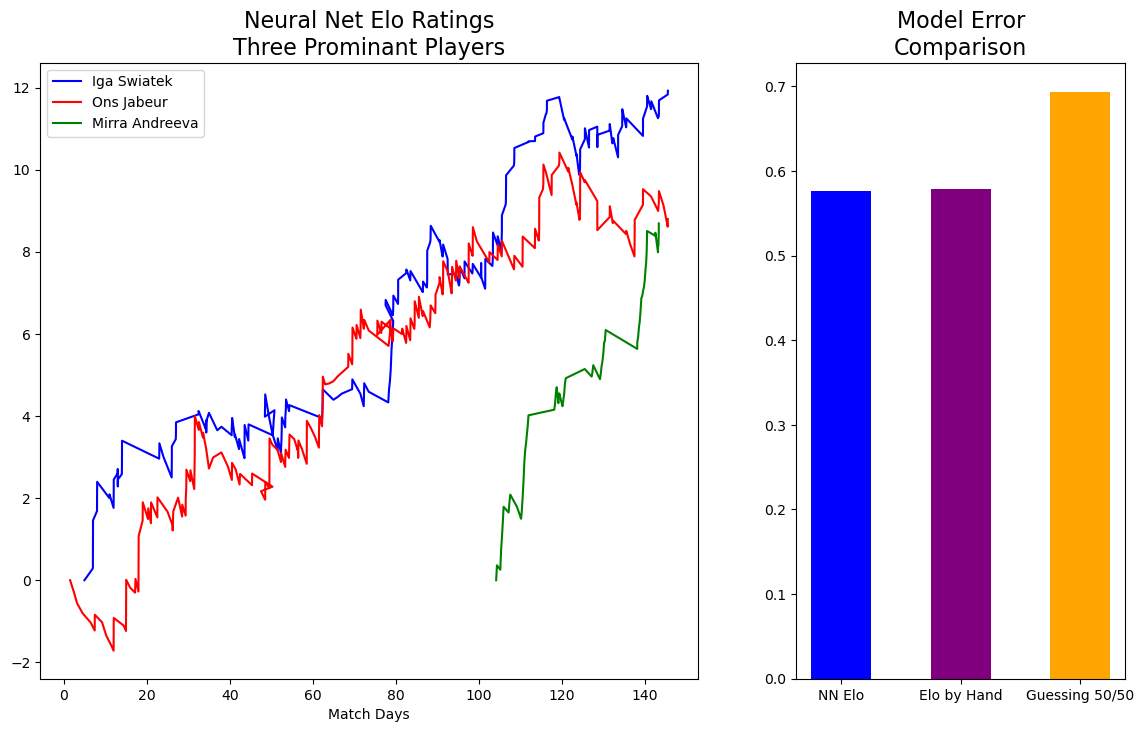

In [126]:

import matplotlib.pyplot as plt
from matplotlib import gridspec

fig = plt.figure(figsize=(14, 8)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1]) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax0.plot(swia.day_num, swia.p1_rating, color='blue', label='Iga Swiatek')
ax0.plot(ons.day_num, ons.p1_rating, color='red', label='Ons Jabeur')
ax0.plot(andreeva.day_num, andreeva.p1_rating, color='green', label='Mirra Andreeva')
ax0.set_xlabel('Match Days')
ax0.legend()
ax0.set_title("Neural Net Elo Ratings\nThree Prominant Players", fontsize=16)
ax1.bar(bar_chart.model_name, bar_chart.model_log_loss, width=0.5, color=['blue','purple','orange'])
ax1.set_title("Model Error\nComparison", fontsize=16)
plt.savefig("C://Users/Blake/Downloads/NN_elo.png")
plt.show()


In [130]:


for name, param in predict_model.named_parameters():
    print(name, param)

for name, param in update_model.named_parameters():
    print(name, param)


linear.weight Parameter containing:
tensor([[-0.5497]], requires_grad=True)
linear.weight Parameter containing:
tensor([[0.5815]], requires_grad=True)


In [131]:

rtg_df = rtg_df.sort_values(by='rating', ascending=False).reset_index(drop=True)

rtg_df.head(60)



,id,name,rating,world_rank
0,216347,Iga Swiatek,11.382395,200
1,214544,Aryna Sabalenka,10.541368,200
2,202458,Ashleigh Barty,10.433446,200
3,201520,Petra Kvitova,10.094959,200
4,214981,Elena Rybakina,9.939775,200
5,214096,Karolina Muchova,9.521082,200
6,211533,Jelena Ostapenko,9.089464,200
7,206420,Ekaterina Alexandrova,9.089188,200
8,202468,Jessica Pegula,9.043121,200
9,201619,Madison Keys,8.997704,200



### More Advanced Model



In [716]:

import torch.nn as nn

class PairwisePredictNN(nn.Module):
    """
    takes [
    player 2 vec - player 1 vec (distance), 
    surface one hot encoding
    ] and predicts match outcome
    """
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(6, 4)
        self.linear2 = nn.Linear(4, 2)

    def forward(self, x):
        x = self.linear(x)
        return torch.sigmoid(self.linear2(x))
    
class PairwiseUpdateNN(nn.Module):
    def __init__(self):
        super().__init__()
        """
        takes [
        player 2 vec - player 1 vec (distance), 
        player 1 node information (games played and direction misses),
        ## not yet -> player 2 node information, 
        surface one hot encoding,
        results
        ] and updates player vecs games
        """
        self.linear = nn.Linear(10, 4) 
        self.linear2 = nn.Linear(4, 2)
        
    def forward(self, x):
        x = self.linear(x)
        return self.linear2(x)
    
class NetworkNode(PlayerNode):
    def __init__(self,_id, name, rating=((torch.rand(2)-0.5)*50+torch.ones(2)*1500).float()):
        super().__init__(rating)
        self._id = _id
        self.name = name
        self.rating = rating
        self.last_rating = rating
        self.games_played = 0
        self.directional_misses = [0]
        ### vector created at end of last match (used to train update model)
        ### includes p2-p1 embedding vector, surface ohe, additional_data, result
        self.last_vector = torch.cat([torch.zeros(2), torch.zeros(4), torch.Tensor([0.5,0.5])])
        # tracking world ranking for comparison
        self.rank = 200 
        
    def get_update_input(self):
        weight = np.array([(0.90**i)*num for i, num in enumerate(self.directional_misses)])
        dir_miss = np.mean(weight*np.array(self.directional_misses))
        return torch.cat([self.last_vector,  torch.Tensor([self.games_played, dir_miss])])

test = NetworkNode(100, "Blake")
test.get_update_input()



tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.5000, 0.0000,
        0.0000])

In [717]:
test.rating

tensor([1488.6625, 1481.9391])

In [718]:

wta_sample_data = wta_sample_data.sort_values(by=['tourney_date','match_num']).reset_index(drop=True)
## one hot encode surface
wta_sample_data['hard'] = np.where(wta_sample_data['surface']=='Hard', 1, 0)
wta_sample_data['clay'] = np.where(wta_sample_data['surface']=='Clay', 1, 0)
wta_sample_data['carpet'] = np.where(wta_sample_data['surface']=='Carpet', 1, 0)
wta_sample_data['grass'] = np.where(wta_sample_data['surface']=='Grass', 1, 0)
print(wta_sample_data[['hard','clay','carpet','grass']].sum())


hard      74858
clay      64638
carpet     2805
grass      3307
dtype: int64


In [719]:

predict_model = PairwisePredictNN()
predict_optimizer = Adam(predict_model.parameters(), lr=1e-6)

update_model = PairwiseUpdateNN()
update_optimizer = Adam(update_model.parameters(), lr=7e-7)


In [720]:

train = wta_sample_data.copy()[:-percent_30]
test = wta_sample_data.copy()[-percent_30:]
batch_size = 64 ## in effect it will be 2x size
num_batches = len(train)//batch_size
num_epochs = 5
best_val_loss = np.inf


In [721]:

def set_scores(x):
    if type(x) is float:
        return '0-0', '0-0', '0-0'
    l = x.strip().split()
    
    num_sets = len(l)
    while len(l) < 3:
        l.append('0-0')
    
    return l

wta_sample_data['set_1_res'], wta_sample_data['set_2_res'], wta_sample_data['set_3_res'] = zip(*wta_sample_data['score'].copy().apply(lambda x: set_scores(x)))


In [722]:
import re

error_maps = {
    '&nbsp;':'1-0',
    'W/O':'1-0',
    'RET':'1-0',
    'DEF':'1-0',
    'BYE':'0-0'
}

res_cols = [f'set_{i}_res' for i in range(1,4)]
for col in res_cols:
    wta_sample_data[col] = wta_sample_data[col].apply(lambda x: error_maps[x] if x in error_maps else x)

def get_set_game_counts(x):
    
    if '-' in x:
        x = x.split('-')
        x_wins = re.findall(r'\d+', x[0])[0]
        wins = int(x_wins[0])
        x_losses = re.findall(r'\d+', x[1])[0]
        losses = int(x_losses)
        return wins, losses
    else:
        return 0, 0
    
    return 

for i in range(1, 4):
    wta_sample_data[f'set_{i}_wins'], wta_sample_data[f'set_{i}_losses'] = zip(*wta_sample_data[f'set_{i}_res'].apply(lambda x: get_set_game_counts(x)))



In [723]:

game_res_cols = []
win_res_cols = []
lose_res_cols = []
for i in range(1, 4):
    game_res_cols.extend([f'set_{i}_wins', f'set_{i}_losses'])
    win_res_cols.extend([f'set_{i}_wins'])
    lose_res_cols.extend([f'set_{i}_losses'])

wta_sample_data['total_games'] = wta_sample_data[game_res_cols].sum(axis=1)
wta_sample_data['total_wins'] = wta_sample_data[win_res_cols].sum(axis=1)
wta_sample_data['game_win_pct'] = wta_sample_data['total_wins'].copy()/wta_sample_data['total_games'].copy()
wta_sample_data['game_win_pct'].fillna(0.7, inplace=True)
wta_sample_data['total_games_pct'] = wta_sample_data['total_games'].copy()/(13*3)


In [724]:

##### turns out there are a lot of nulls ####
# list(wta_sample_data)
# def feature_eng(df):
    
    
#     df['games_won'] = df['']
    
#     return df


In [725]:

for j in range(num_epochs):
    network_player_ratings = {_id:NetworkNode(_id, name) for _id, name in player_names.items()}
    epoch_loss = []
    predict_model.train()
    update_model.train()
    for i in tqdm(range(num_batches-1), total=num_batches-1):
        predict_optimizer.zero_grad()
        update_optimizer.zero_grad()
        train_data = train[i*batch_size:(i+1)*batch_size].copy()

        ## randomize who is p1 and who is p2
        match_participants_1 = train_data[['winner_id','loser_id','winner_rank','loser_rank','hard','clay','carpet','grass','game_win_pct','total_games_pct']]
        rank_dict = match_participants_1.copy().set_index('winner_id').to_dict()['winner_rank']
        rank_2_dict = match_participants_1.copy().set_index('loser_id').to_dict()['loser_rank']
        rank_dict.update(rank_2_dict)

        match_participants_2 = match_participants_1.copy()[['loser_id','winner_id','loser_rank','winner_rank','hard','clay','carpet','grass','game_win_pct','total_games_pct']]
        match_participants_2['game_win_pct'] = 1-match_participants_2['game_win_pct']
        match_participants = pd.concat([match_participants_1, match_participants_2], axis=0).reset_index(drop=True)
        surfaces = match_participants[['hard','clay','carpet','grass']].copy().astype('float32').values
        additional_data = match_participants[['game_win_pct','total_games_pct']].copy().astype('float32').values
        
        match_participants = match_participants.values
        input_order = list(range(batch_size*2))
#         results = torch.cat([torch.ones(batch_size), torch.zeros(batch_size)]).view(-1,1)
        random.shuffle(input_order)
        results = additional_data[input_order].copy()
        
        p1_nodes = [network_player_ratings[match_participants[k][0]] for k in input_order]
        p2_nodes = [network_player_ratings[match_participants[k][1]] for k in input_order]
        
        predict_X = torch.stack([p2_nodes[k].rating-p1_nodes[k].rating for k in range(len(p1_nodes))])
        surface_X = torch.from_numpy(surfaces[input_order])
        additional_X = torch.from_numpy(additional_data[input_order])
        
        predict_X = torch.cat([predict_X, surface_X], axis=1)
        predict_y = torch.from_numpy(results)
        
        update_or_predict = np.random.random()
        ## I found that only updating one model at a time seems to give more stable results
        ## worth investigating further
        if update_or_predict > 0.8: # better chance of update model, that one is more complicated
            ## PREDICT MODEL (easy part)
            predictions = predict_model(predict_X)

            predict_loss = nn.BCELoss()(predictions, predict_y)
            predict_loss.backward()

            # Update the model's parameters
            ## for the first few iterations, let ratings stabilize
            if (j>0)&(i < 20):
                continue
            elif (j>1)&(i < 100):
                continue
            else:
                predict_optimizer.step()
            # Zero the gradients since PyTorch accumulates them
            predict_optimizer.zero_grad()
            update_optimizer.zero_grad()
        
        else:
            ## UPDATE MODEL (slightly harder)
            ## use previous game's results to calculate loss of the update model
            predictions = predict_model(predict_X)
            predict_optimizer.zero_grad()

            ## get previous match information
            p1_update_X = torch.stack([p1_node.get_update_input() for p1_node in p1_nodes])
            p2_update_X = torch.stack([p2_node.get_update_input() for p2_node in p2_nodes])

            p1_update_predictions = update_model(p1_update_X)
            p2_update_predictions = update_model(p2_update_X)

            ## want both baseline predict model (no update) and predict model with updates. Compare to create loss
            baseline_X = torch.stack([p2_nodes[k].last_rating-p1_nodes[k].last_rating for k in range(len(p1_nodes))])
            update_model_X = torch.stack([p2_nodes[k].last_rating+p2_update_predictions[k] - p1_nodes[k].last_rating+p1_update_predictions[k] for k in range(len(p1_nodes))])

            ## take into account surface
            baseline_X = torch.cat([baseline_X, surface_X], axis=1)
            update_model_X = torch.cat([update_model_X, surface_X], axis=1)
            ## no result above because now being used to predict *current* match

            baseline_predictions = predict_model(baseline_X)
            update_model_predictions = predict_model(update_model_X)
            baseline_BCE = nn.BCELoss()(baseline_predictions, predict_y)
            update_model_BCE = nn.BCELoss()(update_model_predictions, predict_y)
            ## lower is better, has to be negative if improving ratings
            update_loss = update_model_BCE-baseline_BCE
            update_loss.backward()
            ## skip the first few iterations of the later epochs to give some time for ratings to develop
            if (j>0)&(i < 25):
                continue
            elif (j>1)&(i < 100):
                continue
            else:
                update_optimizer.step()
            update_optimizer.zero_grad()

            ## both models trained, now actually update
            update_X = torch.stack([p2_nodes[k].rating-p1_nodes[k].rating for k in range(len(p1_nodes))])
            update_X = torch.cat([update_X, surface_X, additional_X], axis=1)

            for l, player_node in enumerate(p1_nodes):
                player_node.last_vector = update_X[l]
                player_node.games_played+=1
#                 player_node.directional_misses.insert(0, float(additional_X[l]-predictions[l]))
#                 if len(player_node.directional_misses)>10:
#                     player_node.directional_misses.pop()

            pred_error = predict_y - predictions
            epoch_loss.extend(list(pred_error[:,0].detach().numpy()))
            complete_update_X = torch.stack([p1_node.get_update_input() for p1_node in p1_nodes])
            updates = update_model(complete_update_X)
            new_ratings = [p1_nodes[k].rating+updates[k] for k in range(len(p1_nodes))]
            for l, player_node in enumerate(p1_nodes):
                player_node.last_rating = player_node.rating.detach().clone()
                player_node.rating = new_ratings[l].detach().clone()
                player_node.rank = rank_dict[player_node._id]
                network_player_ratings[player_node._id] = copy(player_node)

    ## calculate val
    predict_model.eval()
    update_model.eval()
    
    network_player_ratings = {_id:NetworkNode(_id, name) for _id, name in player_names.items()}

    nn_history = []
    for index, row in tqdm(wta_sample_data.iterrows(), total=len(wta_sample_data)):
        ## randomize who is p1 and who is p2
        match_participants = [row['winner_id'], row['loser_id']]
        surface  = torch.from_numpy(row[['hard','clay','carpet','grass']].values.astype('float32'))
        additional = torch.from_numpy(row[['game_win_pct','total_games_pct']].values.astype('float32'))
        additional_2 = additional.detach().clone()
        additional_2[0] = 1-additional_2[0]
        random.shuffle(match_participants)
        p1_id, p2_id = match_participants
        
        p1_nn_node = network_player_ratings[p1_id]
        p2_nn_node = network_player_ratings[p2_id]
#         result = 1 if p1_nn_node._id == row['winner_id'] else 0

        rtg_diff_1 = p2_nn_node.rating-p1_nn_node.rating
        rtg_diff_2 = p1_nn_node.rating-p2_nn_node.rating
        nn_prediction_1 = predict_model(torch.cat([rtg_diff_1, surface]))
        nn_prediction_2 = predict_model(torch.cat([rtg_diff_2, surface]))
        
        nn_prediction = torch.mean(torch.cat([nn_prediction_1, nn_prediction_2]))
        error = result - nn_prediction
        
        p1_update_X = torch.cat([rtg_diff_1, surface, additional]).float()
        p2_update_X = torch.cat([rtg_diff_2, surface, additional_2]).float()
        
        p1_nn_node.last_vector = p1_update_X
        p2_nn_node.last_vector = p2_update_X
        p1_nn_node.games_played+=1
        p2_nn_node.games_played+=1
#         p1_nn_node.directional_misses.insert(0, float(error))
#         p2_nn_node.directional_misses.insert(0, float(1-error))
#         if len(p1_nn_node.directional_misses) > 10:
#             p1_nn_node.directional_misses.pop()
#         if len(p2_nn_node.directional_misses) > 10:
#             p2_nn_node.directional_misses.pop()
        
        p1_rtg_update = update_model(p1_nn_node.get_update_input())
        p2_rtg_update = update_model(p2_nn_node.get_update_input())
        
        id_data = [p1_nn_node._id, p1_nn_node.name, p2_nn_node._id, p2_nn_node.name]
        torch_data = torch.cat([p1_nn_node.rating, p2_nn_node.rating, torch.Tensor([nn_prediction, result]), p1_rtg_update, p2_rtg_update])
        id_data.extend(list(torch_data.detach().numpy()))
        nn_history.append(id_data)
        p1_nn_node.last_rating = p1_nn_node.rating.detach().clone()
        p2_nn_node.last_rating = p2_nn_node.rating.detach().clone()
        p1_nn_node.rating = p1_nn_node.rating + p1_rtg_update
        p2_nn_node.rating = p2_nn_node.rating + p2_rtg_update
        network_player_ratings[p1_id] = copy(p1_nn_node)
        network_player_ratings[p2_id] = copy(p2_nn_node)


    nn_hist = pd.DataFrame(nn_history, columns=['p1_id','p1_name','p2_id','p2_name',
                                                'p1_rating_x','p1_rating_y','p2_rating_x','p2_rating_y',
                                                'prediction','result','p1_ratings_delta_x','p1_ratings_delta_y',
                                                'p2_ratings_delta_x','p2_ratings_delta_y'
                                               ])
    
    val_loss = log_loss(nn_hist[-grade_cutoff:]['result'].values, nn_hist[-grade_cutoff:]['prediction'].values)
    print(f"NN validation log loss: {val_loss}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        print("Saving parameters...")
        torch.save(predict_model.state_dict(), 'pairwise_predict_nn_best_model.pth')
        torch.save(update_model.state_dict(), 'pairwise_update_nn_best_model.pth')


  0%|                                                                                 | 1/1591 [00:00<00:30, 52.63it/s]


TypeError: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'

In [ ]:

nn_hist


In [ ]:
p2_nn_node.rating

In [ ]:
additional_2

In [ ]:
surface

In [ ]:
torch.cat([rtg_diff_1, surface])

In [264]:
print(p1_update_X.round())

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 6.5600e+03])


In [ ]:

predict_model(torch.from_numpy(rds))


In [ ]:
for name, param in predict_model.named_parameters():
    print(name, param)

### Testing PredictNN

In [ ]:


predict_model = EloPredictNN()
predict_optimizer = SGD(predict_model.parameters(), lr=0.01)

for epoch in range(5):
    for index, row in 







In [ ]:

update_model = EloUpdateNN()
predict_optimizer = SGD(predict_model.parameters(), lr=0.01)
update_optimizer = SGD(update_model.parameters(), lr=0.01)
bce_loss = nn.BCELoss()

In [ ]:

class NetworkNode(PlayerNode):
    def __init__(self,_id, name, rating=0):
        super().__init__(rating)
        self._id = _id
        self.name = name
        self.rating = rating
        self.rank = 200 
        
        
network_player_ratings = {_id:NetworkNode(_id, name, np.random.random()-0.5) for _id, name in player_names.items()}


In [ ]:

class PredictNN():
    def __init__(self):
        super().__init__()
        
        self.match_pred_net = nn.Sequential(
            nn.Linear(2, 1),
            nn.Sigmoid()
        )
        
    def forward(self, player1_rating, player2_rating, match_result):
        
        # Make match prediction
        _input = torch.cat([player1_rating, player2_rating], dim=1)
        pred = self.match_pred_net(_input)
        
        # Compute prediction loss
        loss = binary_cross_entropy(pred, match_result)
        return loss
    




In [ ]:

import torch
import torch.nn as nn

class NetworkModel(nn.Module):

    def __init__(self):
        super().__init__()
        
        # Neural network layers        
        self.rating_update_net = nn.Sequential(
            nn.Linear(2, 2),
            nn.ReLU(),
            nn.Linear(2, 1)
        )
        
        self.match_pred_net = nn.Sequential(
            nn.Linear(2, 2),
            nn.ReLU(), 
            nn.Sigmoid()
        )
        
    def forward(self, player1_rating, player2_rating, match_result):
        
        # Make match prediction
        _input = torch.cat([player1_rating, player2_rating], dim=1)
        pred = self.match_pred_net(_input)
        
        # Compute prediction loss
        loss = binary_cross_entropy(pred, match_result)
        
        # Update player ratings based on match result
        rating_delta1 = self.rating_update_net(torch.cat([player1_rating, player2_rating, match_result]))
        rating_delta2 = self.rating_update_net(torch.cat([player2_rating, player1_rating, 1-match_result]))
        
        player1_rating += rating_delta1
        player2_rating += rating_delta2
        
        return loss, player1_rating, player2_rating


In [ ]:



elo_sys = EloSystem(k_factor=50)
player_ratings = {_id:EloNode(_id, name, 1500) for _id, name in player_names.items()}
for index, row in tqdm(wta_sample_data.iterrows(), total=len(wta_sample_data)):
    ## randomize who is p1 and who is p2
    match_participants = [row['winner_id'], row['loser_id']]
    random.shuffle(match_participants)
    p1_id, p2_id = match_participants
    p1_node = player_ratings[p1_id]
    p2_node = player_ratings[p2_id]
    result = 1 if p1_node._id == row['winner_id'] else 0
    p1_node, p2_node = elo_sys.play_match(p1_node, p2_node, result)
    
    ## just tracking world ranking
    if result == 1:
        p1_node.rank = row['winner_rank']
        p2_node.rank = row['loser_rank']
    else:
        p1_node.rank = row['loser_rank']
        p2_node.rank = row['winner_rank']
    player_ratings[p1_id] = p1_node
    player_ratings[p2_id] = p2_node
    
    
hist = elo_sys.get_history()





In [ ]:

import torch
import torch.nn as nn

class SportsRatingModel(nn.Module):

    def __init__(self):
        super().__init__()
        
        # Neural network layers        
        self.rating_update_net = nn.Sequential(
            nn.Linear(2, 2),
            nn.ReLU(),
            nn.Linear(2, 1)
        )
        
        self.match_pred_net = nn.Sequential(
            nn.Linear(2, 2),
            nn.ReLU(), 
            nn.Sigmoid()
        )
        
    def forward(self, player1_rating, player2_rating, match_result):
        
        # Make match prediction
        _input = torch.cat([player1_rating, player2_rating], dim=1)
        pred = self.match_pred_net(_input)
        
        # Compute prediction loss
        loss = binary_cross_entropy(pred, match_result)
        
        # Update player ratings based on match result
        rating_delta1 = self.rating_update_net(torch.cat([player1_rating, player2_rating, match_result]))
        rating_delta2 = self.rating_update_net(torch.cat([player2_rating, player1_rating, 1-match_result]))
        
        player1_rating += rating_delta1
        player2_rating += rating_delta2
        
        return loss, player1_rating, player2_rating
        
        


In [ ]:

hist.loc[(hist['p1_id']==216347)|(hist['p2_id']==216347)]


In [ ]:
test['score']

In [ ]:
test.loc[test['tourney_id']=='2019-0300']

In [ ]:
list(test)

In [ ]:
list(reg)

In [ ]:

reg = []

reg = pd.read_csv(os.path.join(DATA_PATH, 'wta_matches_2019.csv'))
